<a href="https://colab.research.google.com/github/leeoos/sentence-classification/blob/main/src/hw1b_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 1 B

In [25]:
#@title Notebook set up
compare_tokenizers = False
use_cached = False
get_from_git = False
split_before = True
clean = True
stopwords = True

!rm -r /content/datasets/ >> /dev/null

rm: cannot remove '/content/datasets/': No such file or directory


## TODO:

1. split before creating the dataset --> DONE
2. change hyperparameters and network
3. evaluate simple baseline --> DONE
4. implement complex baseline
5. clean dataset (optional)
6. custom tokenizer (optional)

## Imports

In [2]:
#@title Additional Modules

!pip install -q spacy
!python -m spacy download it_core_news_sm >> /dev/null

!pip install -q nltk

!pip install -q --timeout=20 stanza

# if allowed
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 990.1/990.1 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.8/433.8 kB 32.8 MB/s eta 0:00:00


In [4]:
#@title Python Imports

# general imports
import os
import shutil
from tqdm.notebook import tqdm

# data manipulation
import re
import json
import random
import subprocess
from pathlib import Path
from torchtext.vocab import Vocab, vocab
from collections import Counter, OrderedDict

# pretrained embeddig
import gensim

# tokenization
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('italian'))

stanza_available = True
try:
  import stanza
except:
  print("Warning: stanza non available")
  stanza_available = False

# if allowed
from transformers import AutoTokenizer

# statistics
import numpy as np
import matplotlib as plt

# torch
import torch
from torch import nn
import torch.optim as optim
from torch.nn import functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils.rnn import pack_padded_sequence
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau, _LRScheduler, StepLR

torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device: {device}")

### Update some packages ###
# !pip install -q conllu
# !pip install -q torchtext==0.6.0

device: cpu


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Preprocessing

In [20]:
#@title Get Data

if not os.path.exists("sentence-classification"):
  !git clone -q https://github.com/leeoos/sentence-classification.git

# set up paths
train_path = Path("sentence-classification/data/sentipolc16_task1_train_data.jsonl")
test_path = Path("sentence-classification/data/sentipolc16_task1_test_data.jsonl")

def sample_random_lines(filename, num_lines=10, split=False):
    with open(filename, 'r') as file:
      lines = file.readlines()
    # Sample N random lines where N is num_lines or len(lines)
    sampled_lines = random.sample(lines, min(num_lines, len(lines)))

    train_path = filename
    val_path = ''

    sub_split_dir = "subsplit/"
    if os.path.exists(sub_split_dir):
      shutil.rmtree(sub_split_dir)

    if split:
      remaining_lines = [line for line in lines if line not in sampled_lines]
      os.makedirs(sub_split_dir, exist_ok=True)

      # save new train set
      train_path = Path(sub_split_dir + "train_sentipolc16.jsonl")
      remaining_lines[-1] = remaining_lines[-1].rstrip('\n') # remove last '\n'
      with open(train_path, 'w') as file:
        file.writelines(remaining_lines)

      # save new val set
      val_path = Path(sub_split_dir + "val_sentipolc16.jsonl")
      sampled_lines[-1] = sampled_lines[-1].rstrip('\n') # remove last '\n'
      with open(val_path, 'w') as file:
        file.writelines(sampled_lines)

    return sampled_lines, train_path, val_path

def print_random_json_lines(random_lines):
  for line in random_lines:
    try:
      json_data = json.loads(line.strip())
      print(json_data)
    except json.JSONDecodeError:
      print("Error decoding JSON from line:", line)

random_samples, _, _ = sample_random_lines(train_path, num_lines=10)
print_random_json_lines(random_samples)

# to speed up testing just load torcgh dataset from git
if get_from_git:
  !mkdir -p /content/datasets/{device}/
  !cp sentence-classification/cache/{device}/*.pth /content/datasets/{device}

{'id': 193076467377246210, 'text': '"noi non abbiamo leader che ci comandano"  Bene e in che direzione andate? Quali idee? Uno contro tutti? #Grillo #Serviziopubblico #m5s', 'topic': 'politico', 'choices': ['oggettivo', 'soggettivo'], 'label': 0}
{'id': 134749228848250881, 'text': "Pare che Mario Monti abbia escogitato le scie chimiche e l'11 settembre #serviziopubblico @Serv_Pubblico #sapevatelo", 'topic': 'politico', 'choices': ['oggettivo', 'soggettivo'], 'label': 1}
{'id': 195542995452428292, 'text': 'Guai confondere  #Grillo col Movimento 5 stelle – Il Fatto Quotidiano http://t.co/YBJrHs1d via @fattoquotidiano #m5s #m5sTour', 'topic': 'politico', 'choices': ['oggettivo', 'soggettivo'], 'label': 0}
{'id': 141143389537173505, 'text': 'Il primo vero successo raggiunto dal #governo #monti è che nei talkshow si comincia a parlare di cose serie http://t.co/4J9cHDUG #buongiorno', 'topic': 'politico', 'choices': ['oggettivo', 'soggettivo'], 'label': 1}
{'id': 136093851935973376, 'text': '

In [ ]:
#@title Data Statistics

def statistics(path: Path, info:dict):
  with open(path, 'r', encoding='utf-8') as file:
    num_lines = 0
    num_subj = 0
    num_obj = 0

    for _ in file:
      foo = json.loads(_)
      if foo["choices"][foo["label"]] == "oggettivo":
        num_obj += 1
      else:
        num_subj +=1
      num_lines += 1

    perc_obj = round((num_obj/num_lines)*100, 1)
    perc_subj = round((num_subj/num_lines)*100, 1)
    print(f"Total number of samples: {num_lines}")
    print(f"Objetive samples: {perc_obj}%")
    print(f"Subjetive samples: {perc_subj}%")

    info["size"] = num_lines
    info["obj"] = num_obj
    info["subj"] = num_subj
    info["perc_obj"] = perc_obj
    info["perc_subj"] = perc_subj

train_info = {}
test_info = {}
print("Train-Set charateristics")
statistics(train_path, train_info)
print("\nTest-Set charateristics")
statistics(test_path, test_info)

In [9]:
#@title Tokenization

def set_dictionary(tokenizer_type: str):
  """
  This function is used to load the appropriate language dictionary
  for a given tokenizer
  """
  if tokenizer_type == "spacy":
   return spacy.load('it_core_news_sm')

  elif tokenizer_type == "nltk":
    return WordPunctTokenizer()

  elif tokenizer_type == "stanza":
    stanza.download('it')
    return stanza.Pipeline(lang='it', processors='tokenize')

  # if allowed
  elif tokenizer_type == "bert":
    return AutoTokenizer.from_pretrained("dbmdz/bert-base-italian-xxl-cased")

  else:
    print(f"Error: invalit tokenizer type: {tokenizer_type}")


def get_tokenizer(tokenizer_type: str = "spacy"):
  """
  This function loads the appropriate language dictionary and returns the
  tokenizer according to the input string "tokenizer_type
  """

  if tokenizer_type == "stanza" and not stanza_available:
    tokenizer_type

  nlp = set_dictionary(tokenizer_type)

  def custom_tokenizer(text):
    """
    This inner function implements the actual tokenization process
    """

    if tokenizer_type not in ["spacy", "nltk", "stanza", "bert"]:
      print(f"Error: invalid tokenizer type: {tokenizer_type}")
      return []

    if tokenizer_type == "spacy":
      doc = nlp(text)
      tokens = [token.text for token in doc]
      return tokens

    elif tokenizer_type == "nltk":
      """This tokenizer splits also the symbols inside the URL (links in genral)
      this may be a disadvantage"""
      tokens = nlp.tokenize(text)
      return tokens

    elif tokenizer_type == "stanza":
      doc = nlp(text)
      tokens = [token.text for sentence in doc.sentences for token in sentence.tokens]
      return tokens

    # if allowed
    elif tokenizer_type == "bert":
      tokens = nlp.tokenize(text)
      token_ids = nlp.convert_tokens_to_ids(tokens)
      return tokens, token_ids

    else:
      print("Error")
      return []

  return custom_tokenizer

if compare_tokenizers:

  # get a generic tokenizer
  spacy_tokenizer = get_tokenizer("spacy")
  nltk_tokenizer = get_tokenizer("nltk")
  stanza_tokenizer = get_tokenizer("stanza")
  bert_tokenizer = get_tokenizer("bert")
  print()

  # test different tokenizer on the first  sentences of the train set
  for line in random_samples:
    text = json.loads(line)["text"]
    print(f"Original sentence: {text}")
    spacy_list = spacy_tokenizer(text)
    nltk_list = nltk_tokenizer(text)
    stanza_list = stanza_tokenizer(text)
    bert_list, _ = bert_tokenizer(text)
    print(f"Num of tokens: {len(spacy_list)}", end="\t")
    print(f"Sapcy tokenization: {spacy_list}")
    print(f"Num of tokens: {len(nltk_list)}", end="\t")
    print(f"Nltk tokenization: {nltk_list}")
    print(f"Num of tokens: {len(stanza_list)}", end="\t")
    print(f"Stanza tokenization: {stanza_list}")
    print(f"Num of tokens: {len(bert_list)}", end="\t")
    print(f"Bert tokenization: {bert_list}")
    print()

else:
  print("Tokenizer methods defined")

Tokenizer methods defined


In [ ]:
#@title Data Cleaning

def remove_spl_chars(text):
  # Remove URLs
  # text = re.sub(r'http\S+|www\S+', '', text)
  text = re.sub(r'http\S+|www\S+|\[URL\]', '', text)
  text = re.sub('[^a-zA-Z0-9]', ' ', text)

  # # Remove @mentions
  # text = re.sub(r'@\w+', '', text)
  # # Remove hashtags
  # text = re.sub(r'#\w+', '', text)
  # # Optionally remove special characters or anything else unnecessary
  # text = re.sub(r'[^\w\s]', '', text)
  # # Remove extra spaces
  text = re.sub(r'\s+', ' ', text).strip()
  return text

def remove_stopwords(text):
  return " ".join([word for word in text.split() if word not in STOPWORDS])


print("Clean Json Datasets")
for line in random_samples:
  text = json.loads(line)["text"]
  print(f"Original text:  {text}")
  text = remove_stopwords(text)
  text = remove_spl_chars(text)
  print(f"New text: {text}")
  print()

## Dataset

In [33]:
#@title Dataset Class

class Sentipolc16Dataset(Dataset):

  def __init__(
    self,
    input_file: Path,
    tokenizer_type: str = "spacy",
    device: str = "cuda",
    max_length : int = 1028,
    clean: bool = False,
    stopwords: bool = False,
  ) -> None:
    super().__init__()

    # get specific tokenizer
    tokenizer = get_tokenizer(tokenizer_type)

    # get samples from input file
    self.samples = []
    result = subprocess.run(['wc', '-l', str(input_file)], stdout=subprocess.PIPE)
    total_lines = int(result.stdout.decode('utf-8').split()[0]) + 1
    with open(input_file, "r") as file:
      iterator = tqdm(file, total=total_lines, desc="Processing", unit="line")
      for line in iterator:
        sample = json.loads(line.strip())
        text = sample["text"]
        if stopwords:
          text = remove_stopwords(text)
        if clean:
          text = remove_spl_chars(text)
        sample["tokens"] = tokenizer(text) # adding new entry to original json sample
        self.samples.append(sample)

    # set device
    self.device = torch.device(device)

    # set max sentence length allowed
    self.max_length = max_length

    # initialize indexed data attribute but leave it None
    self.indexed_data: list[dict] | None = None

    # Keep track of padding id
    self.padding_id: int | None = None


  def get_raw_element(self, idx: int) -> dict:
    """
    Utility function that gets the raw sample corresponding to `idx`.
    """
    return self.samples[idx]

  def get_raw_tokens(self) -> list:
    return [sample["tokens"] for sample in self.samples]

  def __len__(self) -> int:
    return len(self.samples)

  def __getitem__(self, idx: int) -> dict:
    if self.indexed_data is None:
      raise RuntimeError(
        "Trying to retrieve samples but dataset has not been indexed yet!"
        + " Be sure to call `.index()` on this object."
        + " If you want to retrieve raw elements, call `.get_raw_elements(idx)"
      )
    return self.indexed_data[idx]

  def get_vocabulary(
    self,
    pad_token: str = "<pad>",
    unk_token: str = "<unk>",
    extra_tokens: list[str] = []
  ) -> Vocab:
    """
    Builds a `torchtext.vocab.Vocab` object from data stored in this object.
    """
    vocab_counter = dict(Counter(token for sent in self.samples for token in sent["tokens"]).most_common())
    vocabulary = vocab(vocab_counter, min_freq=1, specials=[pad_token, unk_token, *extra_tokens])
    vocabulary.set_default_index(vocabulary([unk_token])[0])

    return vocabulary

  def set_padding_id(self, value: int) -> None:
    """
    Set padding id after building vocabulary
    """
    self.padding_id = vocabulary([pad_token])[0]


  def index(self, vocabulary: Vocab) -> None:
    """
    Builds `self.indexed_data` by converting raw samples to input_ids following `vocabulary`
    """
    if self.indexed_data is not None:
      print("Dataset has already been indexed. Keeping old index...")
    else:
      indexed_data = []
      for sample in self.samples:
        indexed_data.append({"input_ids": vocabulary(sample["tokens"]), "label": sample["label"]})
      self.indexed_data = indexed_data

  def _collate_fn(self, raw_batch: list[dict]) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Batches together single elements of the dataset.
    This function:
    - converts each sentence made up of single input_ids to a padded tensor,
    - keeps track of the length of each sentence through `sequence_lengths`
    - builds a `labels` tensor storing the label for each sentence

    Args:
        raw_batch (list[dict]): a list of elements, as returned by the `__getitem__()` function.

    Returns:
        A tuple of three tensors, respectively `(sequence_lengths, padded_sequence, labels)`
    """
    if self.padding_id is None:
      raise RuntimeError("Padding value not set! Set it through .set_padding_id method.")

    # We need these sequence lengths to construct a `torch.nn.utils.rnn.PackedSequence` in the model
    sequence_lengths = torch.tensor([len(sample["input_ids"]) for sample in raw_batch], dtype=torch.long)
    padded_sequence = pad_sequence(
      (
        torch.tensor(sample["input_ids"], dtype=torch.long, device=self.device)
        for sample in raw_batch
      ),
      batch_first=True,
      padding_value=self.padding_id
    )
    labels = torch.tensor([sample["label"] for sample in raw_batch], device=self.device, dtype=torch.long)
    return sequence_lengths, padded_sequence, labels

## Dataloaders Trainer and Evaluation Methods

In [34]:
#@title Make Torch Datasets

cached_dataset = (
    os.path.exists(f"/content/datasets/{device}/train_dataset.pth") and
    os.path.exists(f"/content/datasets/{device}/test_dataset.pth") and
    os.path.exists(f"/content/datasets/{device}/val_dataset.pth") and
    os.path.exists(f"/content/datasets/{device}/vocabulary.pth")
)
pad_token, unk_token = "<pad>", "<unk>"

if (not use_cached) or (not cached_dataset):
  print("Making datasets...")

  if split_before:
    train_path = Path("sentence-classification/data/sentipolc16_task1_train_data.jsonl") # to be on the safe side
    split_size = int(train_info["size"]*0.1) # 10% of the train dataset
    _, train_path, val_path = sample_random_lines(train_path, num_lines=split_size, split=True)
    val_dataset = Sentipolc16Dataset(val_path, device=device, clean=clean, stopwords=stopwords)

  train_dataset = Sentipolc16Dataset(train_path, device=device, clean=clean, stopwords=stopwords)
  test_dataset = Sentipolc16Dataset(test_path, device=device, clean=clean, stopwords=stopwords)

  # build vocabulary
  vocabulary = train_dataset.get_vocabulary(pad_token=pad_token, unk_token=unk_token)
  padding_id = vocabulary([pad_token])[0]
  train_dataset.set_padding_id(padding_id)
  test_dataset.set_padding_id(padding_id)

  # indexing dataset
  train_dataset.index(vocabulary)
  test_dataset.index(vocabulary)

  %rm -r /content/datasets/{device} >> /dev/null
  !mkdir -p /content/datasets/{device}/

  # saving torch dataset
  torch.save(train_dataset, f'/content/datasets/{device}/train_dataset.pth')
  torch.save(test_dataset, f'/content/datasets/{device}/test_dataset.pth')

  print(f"\nTraining len: {len(train_dataset)}")
  print(f"Test len: {len(test_dataset)}")

  if split_before:
    val_dataset.set_padding_id(padding_id)
    val_dataset.index(vocabulary)
    torch.save(val_dataset, f'/content/datasets/{device}/val_dataset.pth')
    torch.save(vocabulary, f'/content/datasets/{device}/vocabulary.pth')

    print(f"Validation len: {len(val_dataset)}")


else:
  print("Using pre-build dataset!")


Making datasets...


Processing:   0%|          | 0/741 [00:00<?, ?line/s]

Processing:   0%|          | 0/6669 [00:00<?, ?line/s]

Processing:   0%|          | 0/2000 [00:00<?, ?line/s]


Training len: 6669
Test len: 2000
Validation len: 741


In [35]:
#@title Make Dataloaders

cached_dataset = (
    os.path.exists(f"/content/datasets/{device}/train_dataset.pth") and
    os.path.exists(f"/content/datasets/{device}/test_dataset.pth") and
    os.path.exists(f"/content/datasets/{device}/val_dataset.pth") and
    os.path.exists(f"/content/datasets/{device}/vocabulary.pth")
)
if use_cached and cached_dataset:
  print("Loading dataset from files")
  train_dataset = torch.load(f"/content/datasets/{device}/train_dataset.pth")
  val_dataset = torch.load(f"/content/datasets/{device}/val_dataset.pth")
  test_dataset = torch.load(f"/content/datasets/{device}/test_dataset.pth")
  vocabulary = torch.load(f"/content/datasets/{device}/vocabulary.pth")
  padding_id = vocabulary([pad_token])[0]


if not split_before:
  # split train dataset to obtain validation dataset
  train_size = int(0.9*len(train_dataset))
  val_size = int(len(train_dataset) - train_size)
  train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

  t_collate_fn = train_dataset.dataset._collate_fn
  v_collate_fn = val_dataset.dataset._collate_fn

else:
  t_collate_fn = train_dataset._collate_fn
  v_collate_fn = val_dataset._collate_fn

# make dataloaders
curr_batch_size = 32
print(f"Making torch dataloaders with batch size: {curr_batch_size}")
training_dataloader = DataLoader(train_dataset, batch_size=curr_batch_size, shuffle=True, collate_fn=t_collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=curr_batch_size, shuffle=False, collate_fn=v_collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=curr_batch_size, shuffle=False, collate_fn=test_dataset._collate_fn)
print("Done!")

Making torch dataloaders with batch size: 32
Done!


In [29]:
#@title Trainer Class

class Trainer():
    """Utility class to train and evaluate a model."""

    def __init__(
        self,
        model: nn.Module,
        optimizer: torch.optim.Optimizer,
        schedulers: list,
        log_steps: int = 1_000,
        log_level: int = 2
    ):
        self.model = model
        self.optimizer = optimizer
        self.schedulers = schedulers
        self.loss_function = nn.CrossEntropyLoss() # this is the default loss used nearly everywhere in NLP

        self.log_steps = log_steps
        self.log_level = log_level

    def train(
        self,
        train_dataloader: DataLoader,
        valid_dataloader: DataLoader,
        epochs: int = 1
    ) -> dict[str, list[float]]:
      """
      Args:
        train_dataloader: a DataLoader instance containing the training instances.
        valid_dataloader: a DataLoader instance used to evaluate learning progress.
        epochs: the number of times to iterate over train_dataset.

      Returns:
        avg_train_loss: the average training loss on train_dataset over epochs.
      """
      assert epochs >= 1 and isinstance(epochs, int)
      if self.log_level > 0:
        print('Training ...')
      train_loss = 0.0

      losses = {
        "train_losses": [],
        "valid_losses": [],
        "valid_acc": [],
      }

      for epoch in range(1, epochs + 1):
        if self.log_level > 0:
            print(' Epoch {:2d}'.format(epoch))

        epoch_loss = 0.0
        train_acc = 0.0
        self.model.train()

        # for each batch
        for step, (sequence_lengths, inputs, labels) in enumerate(train_dataloader):

          self.optimizer.zero_grad()
          predictions = self.model((sequence_lengths, inputs))

          # The CrossEntropyLoss expects the predictions to be logits, i.e. non-softmaxed scores across
          # the number of classes, and the labels to be a simple tensor of labels.
          sample_loss = self.loss_function(predictions, labels)
          sample_loss.backward()
          self.optimizer.step()

          epoch_loss += sample_loss.cpu().tolist()

          # train accuracy
          sample_acc = self._compute_acc(predictions, labels)
          train_acc += sample_acc


          if self.log_level > 1 and (step % self.log_steps) == (self.log_steps - 1):
            print('\t[E: {:2d} @ step {}] current avg loss = {:0.4f}'.format(epoch, step, epoch_loss / (step + 1)))

        avg_epoch_loss = epoch_loss / len(train_dataloader)
        avg_train_acc = train_acc / len(train_dataloader)

        if self.log_level > 0:
          print('\t[E: {:2d}] train loss = {:0.4f}, train_acc = {:0.4f}'.format(epoch, avg_epoch_loss, avg_train_acc))

        valid_loss, valid_acc = self.evaluate(valid_dataloader)

        losses["train_losses"].append(avg_epoch_loss)
        losses["valid_losses"].append(valid_loss)
        losses["valid_acc"].append(valid_acc)

        # Scheduler step depending on its type
        for scheduler in self.schedulers:
          if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(valid_loss)
          elif isinstance(scheduler, StepLR):
            scheduler.step()
          else:
            pass

        if self.log_level > 0:
          print('\t[E: {:2d}] valid loss = {:0.4f}, valid acc = {:0.4f}'.format(epoch, valid_loss, valid_acc))
          current_lr = self.optimizer.param_groups[0]['lr']
          print(f"\tlearning rate: {current_lr}")

      if self.log_level > 0:
          print('... Done!')

      return losses

    def _compute_acc(self, logits: torch.Tensor, labels: torch.Tensor) -> float:
      predictions = torch.argmax(logits, dim=1) # each element is 0 if the 0-class had higher logit, 1 otherwise.
      return torch.mean((predictions == labels).float()).tolist() # type: ignore

    def evaluate(self, curr_dataloader: DataLoader, check_len: bool = False) -> tuple[float, float]:
      """
      Args:
        curr_dataloader: the DataLoader to use to evaluate the model.

      Returns:
          avg_curr_loss: the average validation loss over curr_dataloader.
      """
      curr_loss = 0.0
      curr_acc = 0.0
      self.model.eval()
      with torch.no_grad():
        for batch in curr_dataloader:
          sequence_lengths, inputs, labels = batch

          logits = self.model((sequence_lengths, inputs))

          sample_loss = self.loss_function(logits, labels)
          curr_loss += sample_loss.tolist()

          sample_acc = self._compute_acc(logits, labels)
          curr_acc += sample_acc

      if check_len:
        print(f"Len of current dataloader (num of batches): {len(curr_dataloader)}")

      return curr_loss / len(curr_dataloader), curr_acc / len(curr_dataloader),

    def predict(self, batch: tuple[torch.Tensor, torch.Tensor]) -> tuple[torch.Tensor, torch.Tensor]:
      """
      Args:
          x: a tensor of indices
      Returns:
          A tuple composed of:
          - the logits of each class, 0 and 1
          - the prediction for each sample in the batch
            0 if the sentiment of the sentence is negative, 1 if it is positive.
      """
      self.model.eval()
      with torch.no_grad():
        sequence_lengths, inputs = batch
        logits = self.model(sequence_lengths, inputs) # [B, 2]
        predictions = torch.argmax(logits, -1) # computed on the last dimension of the logits tensor
        return logits, predictions

## Baselines

In [36]:
#@title Statify Approach

class StratifyModel(torch.nn.Module):

  def __init__(
      self,
      perc_obj: float,
      perc_subj: float,
      device: str = "cuda"
  ) -> None:
    super().__init__()

    self.device = device
    self.obj = perc_obj / 100
    self.subj = perc_subj / 100

    assert self.obj + self.subj == 1.0, "The percentagese should add to 1"

  def forward(self, batch: tuple[torch.Tensor, torch.Tensor]) -> torch.Tensor:
    sequence_lengths, input_ids = batch

    # get the batch size from the input_ids tensor
    batch_size = input_ids.size(0)

    # Generate a random tensor of the same batch size
    random_probs = torch.rand(batch_size)

    # Allocate tensor for the output probabilities
    output_probs = torch.zeros(batch_size, 2)

    # Assign first number greater than 0.5 based on perc_obj probability
    # https://pytorch.org/docs/stable/generated/torch.where.html
    output_probs[:, 0] = torch.where(
                            random_probs < self.obj,
                            random_probs / 2 + 0.5,   # True: random number > 0.5
                            random_probs / 2          # False: random number <= 0.5
                          )

    # Second number is just 1 - first_number
    output_probs[:, 1] = 1 - output_probs[:, 0]

    output_probs = output_probs.to(self.device)

    return output_probs


stratify_baseline = StratifyModel(train_info["perc_obj"], train_info["perc_subj"], device=device)
baseline_trainer = Trainer(
    model=stratify_baseline,
    optimizer=None,
    schedulers=None,
    log_steps=100,
    log_level = 1,
)

print("Direct evaluation of stratify baseline")
test_loss, test_acc = baseline_trainer.evaluate(curr_dataloader=test_dataloader, check_len=True)
print(f"Test loss {test_loss}, Test accuracy: {test_acc}")

Direct evaluation of stratify baseline
Len of current dataloader (num of batches): 63
Test loss 0.6760496383621579, Test accuracy: 0.5808531746031746


In [45]:
#@title Word2Vec Baseline

avg_len = 10

def add_labels(corpus: list) -> list:

  new_corpus = []
  list_of_lens = []
  for index, tokens in enumerate(corpus):
    sample = train_dataset.get_raw_element(index)
    label = sample['choices'][sample['label']]
    tokens_labels = tokens + [label]
    new_corpus.append(tokens_labels)

    # track average text len to make windos size
    list_of_lens.append(len(tokens))

  avg_len = sum(list_of_lens)/index
  print(f"average sequence len: {avg_len}")
  return new_corpus

train_corpus = add_labels(train_dataset.get_raw_tokens())
val_corpus = add_labels(val_dataset.get_raw_tokens())
corpus = train_corpus + val_corpus


print(corpus[0])

print(len(corpus))

# word_model = gensim.models.Word2Vec(corpus, vector_size=100, window=2, epochs=20, min_count=1)

average sequence len: 10.441361727654469
average sequence len: 10.571621621621622
['Intanto', 'partita', 'Via', 'Nazionale', 'complica', 'Saccomanni', 'dice', 'mica', 'Mario', 'Monti', 'via', 'linkiesta', 'soggettivo']
7410


In [49]:
model = gensim.models.Word2Vec(window=max(len(s) for s in corpus), min_count=1, vector_size=100)

# Build vocabulary
model.build_vocab(corpus)

# Train the model
model.train(corpus, total_examples=model.corpus_count, epochs=10)

(723272, 848560)

In [50]:
model.wv.most_similar("oggettivo")

[('onda', 0.9994392991065979),
 ('ore', 0.9994360208511353),
 ('Milano', 0.9994358420372009),
 ('TV', 0.999417245388031),
 ('Napoli', 0.9994021654129028),
 ('gennaio', 0.999384880065918),
 ('Roma', 0.9993593692779541),
 ('15', 0.9993419647216797),
 ('news', 0.9993324279785156),
 ('Juve', 0.9993252754211426)]

In [56]:
test_samples = test_dataset.get_raw_tokens()
test_labels = [test_dataset.get_raw_element(index)['choices'][test_dataset.get_raw_element(index)['label']] for index in range(len(test_dataset))]

print(len(test_labels))
print(len(test_samples))

assert len(test_labels) == len(test_samples), "Error size do not match"

# for index in range(len(test_dataset)):
#     sample  = test_dataset.get_raw_element(index)
#     print(sample)
#     print(sample['choices'][sample['label']])

sample_acc = 0

for sample, label in zip(test_samples, test_labels):

  acc_obj_score = []
  acc_subj_score = []
  for index, token in enumerate(sample):
    if token not in model.wv:
      # print(f"Waring word: {token} not in {model} dictionary")
      acc_obj_score.append(0)
      acc_subj_score.append(0)
    else:
      acc_obj_score.append(model.wv.similarity(token, "oggettivo"))
      acc_subj_score.append(model.wv.similarity(token, "soggettivo"))


  sentence_obj_score = sum(acc_obj_score) / (index + 1)
  sentence_subj_score = sum(acc_subj_score) / (index + 1)

  # print(sentence_obj_score)
  # print(sentence_subj_score)

  prediction = "oggettivo" if sentence_obj_score > sentence_subj_score else "soggettivo"

  sample_acc += 1 if prediction == label else 0

  # print(f"Prediction: {prediction}")
  # print(f"Label: {label}")

test_acc = sample_acc / len(test_samples)

print(f"Test accuracy: {test_acc}")



2000
2000
Test accuracy: 0.411


## Model

In [ ]:
#@title LSTM Model Class

class LSTMModel(torch.nn.Module):

    def __init__(
        self,
        vocabulary_length: int,
        hidden_dim: int,
        lstm_layers: int,
        lstm_dropout: float,
        bidirectional: bool,
        num_classes: int,
        padding_id: int,
        pretrained_embedding: torch.Tensor = None,
        fine_tune: bool = False,
        device: str = "cuda",
    ) -> None:
        super().__init__()

        # Prepare the device
        self.bidirectional = bidirectional
        self.device = torch.device(device)
        self.in_features = hidden_dim * 2 if bidirectional else hidden_dim
        print(f"device: {self.device}")

        # Embedding layer
        if pretrained_embedding:
            self.embedding = nn.Embedding(
                pretrained_embedding,
                freeze=fine_tune,
                padding_idx=padding_id
            )
        else:
            self.embedding = nn.Embedding(
                num_embeddings=vocabulary_length,
                embedding_dim=hidden_dim,
                padding_idx=padding_id, # avoid updating the gradient of padding entries
                device=self.device
            )

        # LSTM
        self.lstm = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=lstm_dropout,
            bidirectional=bidirectional,
            device=self.device
        )

        # Projection layer --> this could be changed with a more complex logic
        self.projection = nn.Linear(
            in_features=self.in_features,
            out_features=num_classes,
            device=self.device
        )

        print("Embedding Layer")
        print(self.embedding)
        print("LSTM Layer")
        print(self.lstm)
        print("Projection Layer")
        print(self.projection)

    def forward(self, batch: tuple[torch.Tensor, torch.Tensor]) -> torch.Tensor:
      """
      Implementaion of the forward method:
        - input: batch of data orgaized as [sequance_lenghts, token_ids]
        - output: class predictions as logits
      """

      sequence_lengths, input_ids = batch
      embeds = self.embedding(input_ids) # [B, S, H]

      # Pack the sequence to avoid gradient descent on padding tokens.
      packed = pack_padded_sequence(embeds, sequence_lengths, batch_first=True, enforce_sorted=False)

      # hidden_state: [D * num_layers, B, H]
      # cell_state: [D * num_layers, B, C]
      # D = 2 if bidirectional is True else is 1
      packed_output, (hidden_state, cell_state) = self.lstm(packed)

      if self.bidirectional:
        # forward: hidden_state[-2,:,:],
        # backward: hidden_state[-1,:,:]
        hidden = torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim=1) # [B, 2 * H]

      else:
        hidden = hidden_state[-1,:,:]

      logits = self.projection(hidden) # [B, 2]
      return logits

In [ ]:
#@title LSTM Instance

subjectivity_classifier = LSTMModel(
    vocabulary_length=len(vocabulary),
    hidden_dim=8,
    lstm_layers=1,
    lstm_dropout=0,
    bidirectional=False,
    num_classes=2,
    padding_id=padding_id,
    device=device
)

## LSTM Training and Evaluation

In [ ]:
#@title Trainer Instance

optimizer = torch.optim.Adam(
  subjectivity_classifier.parameters(),
  lr=1e-3,
  weight_decay=1e-5
)

# optimizer = torch.optim.SGD(
#     subjectivity_classifier.parameters(),
#     lr=1e-2,
#     momentum=0.8,
#     # weight_decay=0.001,
#     # dampening=0.001,
# )

schedulers = []
schedulers = [
  torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    'min',
    factor=0.1,
    patience=10,
    min_lr=1e-5
  ),
  # torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
]


trainer = Trainer(
    model=subjectivity_classifier,
    optimizer=optimizer,
    schedulers=schedulers,
    log_steps=100,
    log_level = 1,
)

In [ ]:
losses = trainer.train(train_dataloader=training_dataloader, valid_dataloader=val_dataloader, epochs=50)

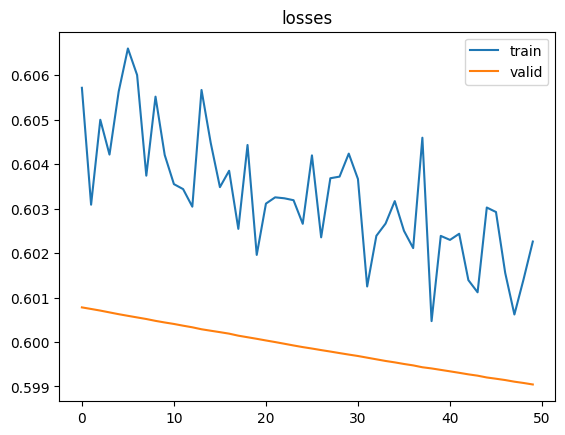

In [ ]:
import matplotlib.pyplot as plt

plt.title("losses")
plt.plot(losses["train_losses"], label="train")
plt.plot(losses["valid_losses"], label="valid")
plt.legend()
plt.show()

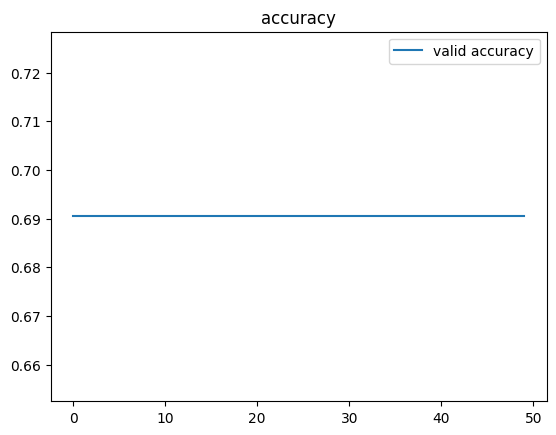

In [ ]:
plt.title("accuracy")
plt.plot(losses["valid_acc"], label="valid accuracy")
plt.legend()
plt.show()

In [ ]:
test_loss, test_acc = trainer.evaluate(curr_dataloader=test_dataloader, check_len=True)
print(f"Test loss {test_loss}, Test accuracy: {test_acc}")

In [ ]:
#@title Saving Best Models
torch.save(subjectivity_classifier, str(test_acc)[:5] + "_checkpoints.pth")